<a href="https://colab.research.google.com/github/Vinod1403/IIIT-Hyderabad-Tutorials/blob/main/STP_Module_2_Lab_3_Manifold_Learning_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 3: Manifold Learning Methods

---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

First let us simulate a dataset with the points lying on a manifold which we would want our Isomap to be able to capture.

We will be using the make_s_curve() function in the sklearn.datasets module to make the manifold using 1000 data points

In [2]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

**Why use the S-curve?**

The S-curve is a classic example of a 2D manifold embedded in 3D space.
It’s non-linear, so linear methods like PCA struggle to "unroll" it, but Isomap can.

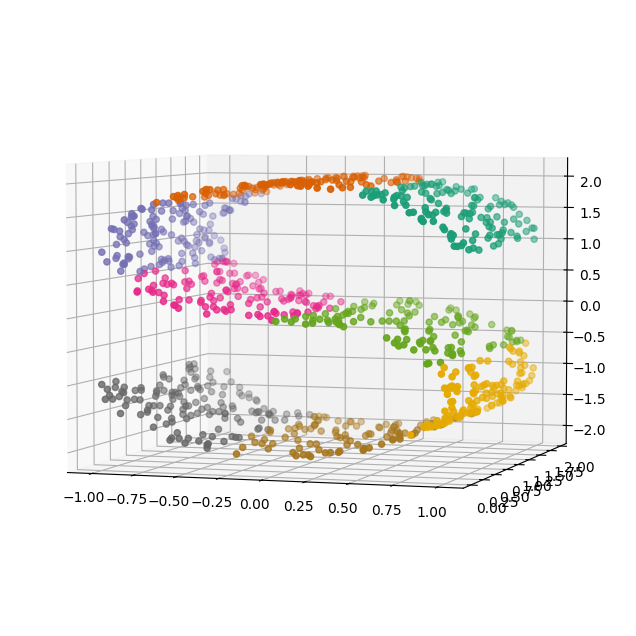

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)
plt.show()

**Observation:**

- The S-curve is a 2D surface (a sheet of paper) bent in 3D space.
- Isomap will try to "unbend" this surface into a flat 2D plane.

Note that all the points appear to be a lying on a curved 2d plane in this 3d dataset. Now we will be coding the Isomap algorithm to perform this manifold learning.


---

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data


In [4]:
def dist(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])
print(distances.shape)


(1000, 1000)


**What’s happening?**

- We compute the Euclidean distance between every pair of points.
- This gives us an N x N matrix, where N is the number of points (1000 here).

### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [5]:
n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k, i in enumerate(sort_distances):
    neighbors[k, i] = distances[k, i]

neighbors.shape

(1000, 1000)

In [ ]:
neighbors.shape

**Adjacency Graph**

**What’s happening?**

- We connect each point to its k nearest neighbors, creating a network (graph).
- This graph approximates the true shape of the manifold.

**Analogy:**

Imagine you’re in a maze. You can only see nearby walls (neighbors). By connecting to your neighbors, you can find the shortest path to any other point in the maze.



---

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

We will be using the graph_shortest_path() function in the sklearn.utils.graph module.

The function takes an array of positive distances as the parameter. It then performs a shortest-path graph search on the graph and returns a matrix G (shape = N,N), where, G(i,j) gives the shortest distance from point i to point j along the graph.


In [6]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)

**Dijkstra’s Algorithm**

**What’s happening?**

- We calculate the shortest path between every pair of points using Dijkstra’s algorithm.
- This gives us the "true" distances along the manifold, not just straight-line distances.

**Example:**

If you’re driving from Delhi to Mumbai, the road distance (geodesic) is longer than the straight-line (Euclidean) distance on a map. Isomap uses the road distance.



---
### Step 3: Take the top d eigenvectors of the Gram matrix.


So let us first compute the gram matrix. If we have a matrix **graph**, then its Gram matrix is **graph**.T * **graph**





In [7]:
gram = (graph ** 2)
n_samples = gram.shape[0]
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1) / n_samples)[:, np.newaxis]
meanall = meanrows.sum() / n_samples
gram -= meanrows
gram -= meancols
gram += meanall

Computing eigenvectors

In [8]:
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

n_components = 2
reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
    reduced_matrix[i, :] = eig_pa_chebyshevirs[i, 1]
reduced_matrix = reduced_matrix.T

**Eigenvectors and the Gram Matrix**

**What’s happening?**

- We compute the Gram matrix (a matrix of inner products) and find its top eigenvectors.
- These eigenvectors give us the coordinates in the lower-dimensional space.

**Analogy:**

Think of the Gram matrix as a "distortion detector." The top eigenvectors help us "unfold" the manifold into a flat space.



---

## Plotting the resultant reduced_matrix


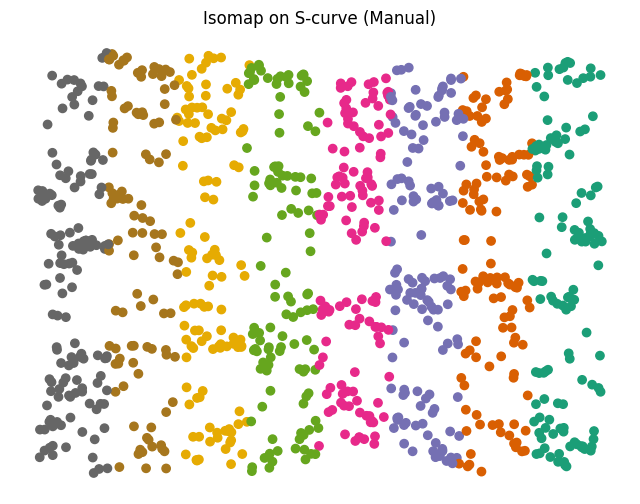

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S-curve (Manual)")
plt.axis('off')
plt.show()

**Isomap on the S-Curve**

**What’s happening in the code?**

- We generate a 3D S-shaped curve.
- We compute pairwise distances and keep only the k nearest neighbors.
- We use Dijkstra’s algorithm to find the shortest paths (geodesics).
- We reduce the data to 2D using eigenvectors.

**Visualization:**

The 3D S-curve is "unrolled" into a 2D plane, preserving the structure.

##### As you can see the Isomap was able to capture the underlying 2d manifold in the S curve dataset.

Now of course there is an easier way to do this, using a predefined library Isomap by sklearn in the manifold module. It just requires you to enter the number of neighbours to be considered and the number of components the graph is to be reduced to.


In [10]:
from sklearn.manifold import Isomap

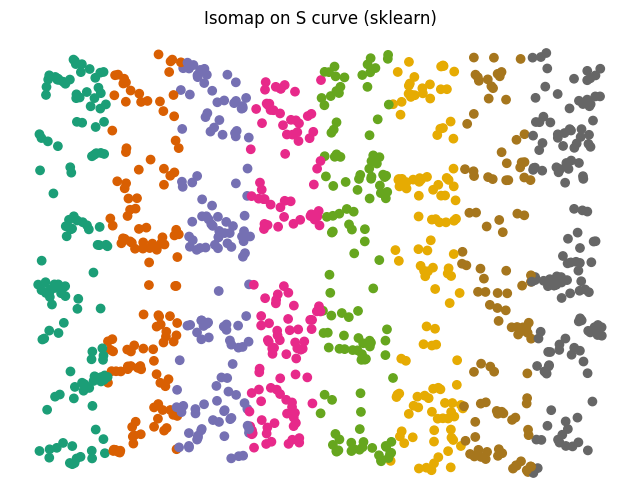

In [11]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve (sklearn)")
plt.axis('off')
plt.show()

**Why Use sklearn?**
**Why use sklearn's Isomap?**

- The manual implementation helps you understand the math, but sklearn is optimized and easier to use.
- It’s also more robust for real-world datasets.



---

### Now let us see if Isomap can learn the manifold representation in some more complex datasets

In [12]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

We loaded 766 images, each having 2914 pixels. Let us visualize our dataset before reducing the dimension

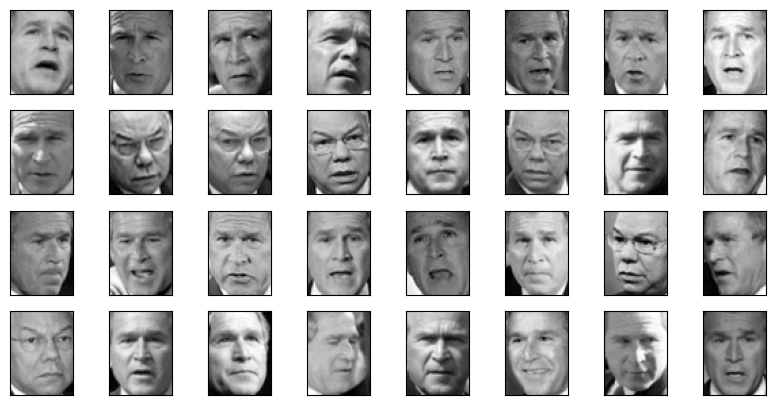

In [13]:
fig, ax = plt.subplots(4, 8, figsize=(10, 5), subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')
plt.show()

**Why Faces?**
**Why use Isomap on faces? **

- Faces are high-dimensional (2914 pixels), but the meaningful variations (e.g., orientation, lighting) lie on a lower-dimensional manifold.
- Isomap reveals these hidden structures.

Our data is 2914 dimensional and our goal is to learn a low dimensional manifold from it. We first apply PCA (which we learn in Lab 2) and see if PCA is able to reduce it to lower dimensions while preserving much of the variance.

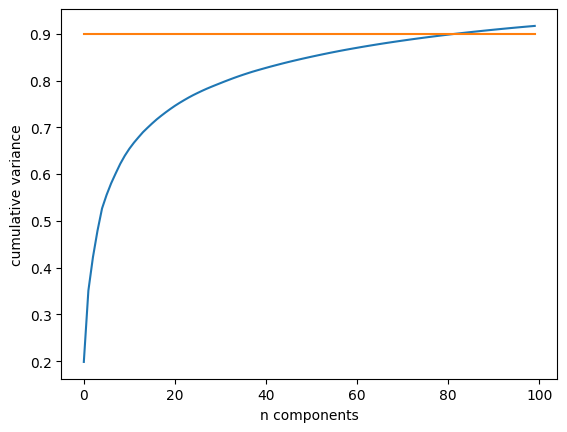

In [14]:
from sklearn.decomposition import PCA as RandomizedPCA

model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))
plt.show()

Let us now try to apply Isomap to this dataset and see if it is able to learn the representation effectively.

In [15]:
model = Isomap(n_components=2, n_neighbors=5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

We have reduced the dataset from 2914 dimensions to just 2 dimensions. Let us now visualize the result to be able to better understand the latent representation learnt by Isomap

In [16]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)

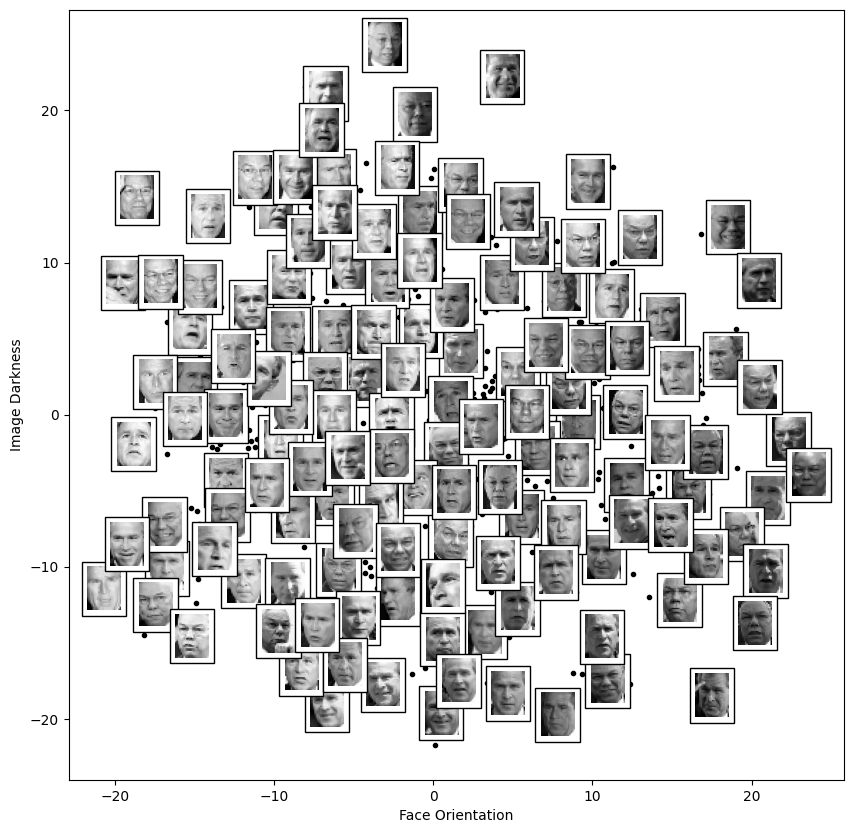

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors=5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")
plt.show()

**PCA vs. Isomap on Faces**

**Observation:**

- PCA needs 70+ dimensions to explain 90% of the variance, implying that PCA is failing to learn the underlying manifold effectively.
- Isomap reduces the data to 2D while preserving meaningful structure (orientation and darkness).

**Interpreting the Face Plot**

**Observation:**

- The 2D plot shows faces arranged by orientation (left to right) and darkness (bottom to top).
- This means Isomap discovered two key features without being told what to look for!

**Example:**

If you sort photos of a person’s face from bright to dark and left-profile to right-profile, you’re doing what Isomap does automatically.



**You are motivated to play around with the number of neighbors and check if the following holds true across neighbourhoods!**

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 7 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.12/dist-pa

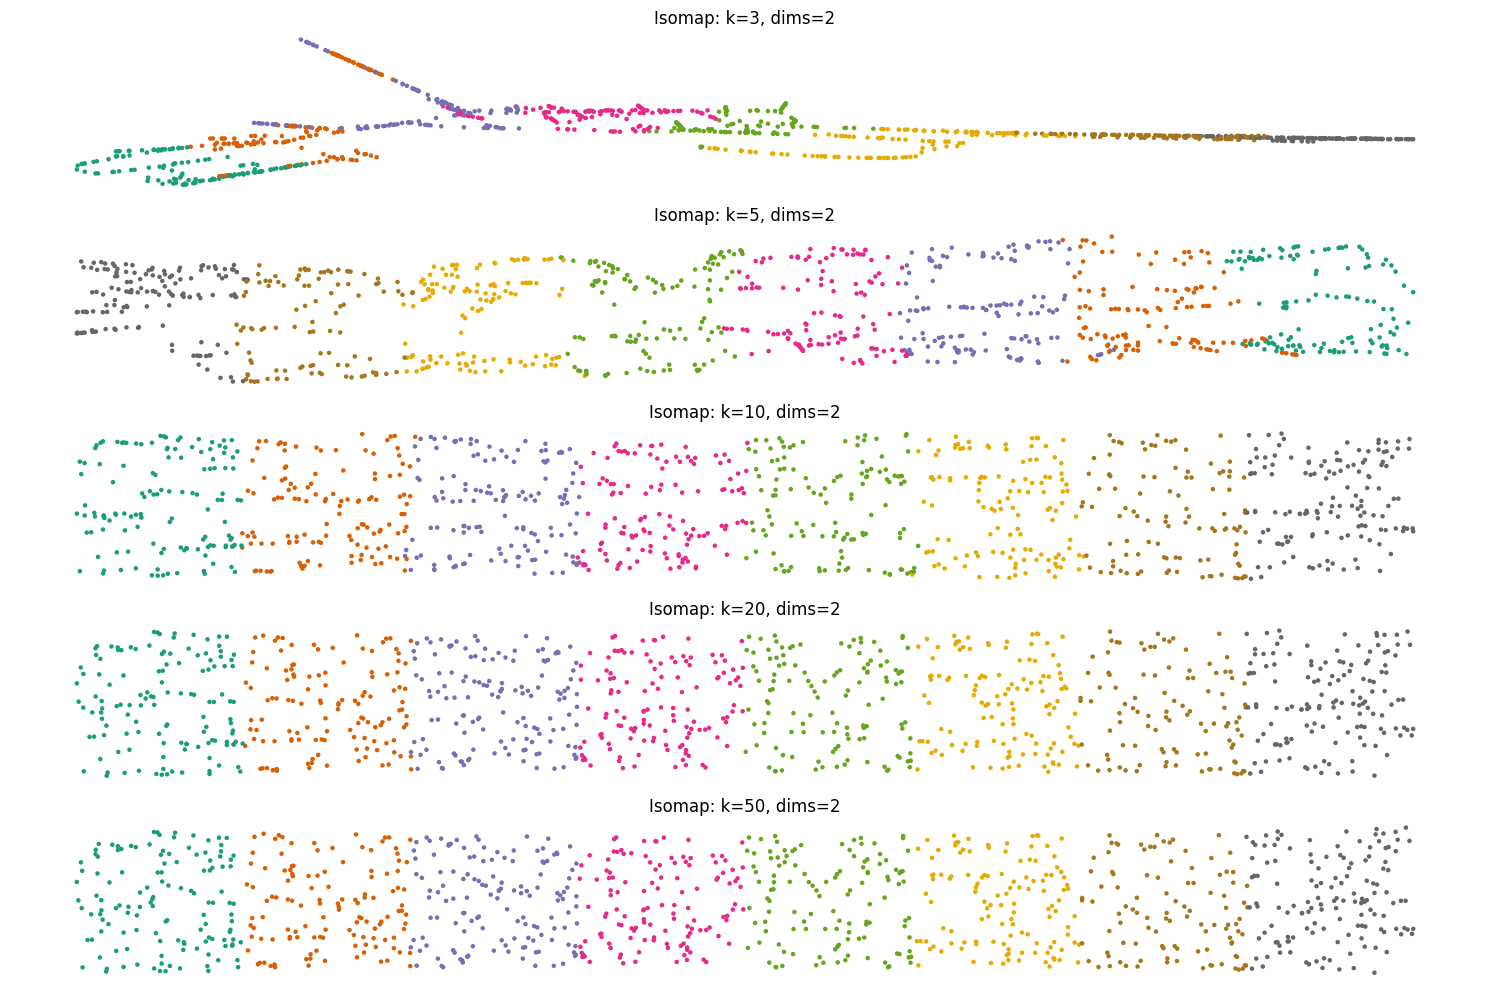

In [18]:
# Try different neighbor and dimension settings
from sklearn.manifold import Isomap

neighbor_values = [3, 5, 10, 20, 50]
component_values = [2]

plt.figure(figsize=(15, 10))

plot_index = 1
for k in neighbor_values:
    for d in component_values:
        model = Isomap(n_neighbors=k, n_components=d)
        Y = model.fit_transform(X)

        plt.subplot(len(neighbor_values), len(component_values), plot_index)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap="Dark2", s=5)
        plt.title(f"Isomap: k={k}, dims={d}")
        plt.axis('off')

        plot_index += 1

plt.tight_layout()
plt.show()

---


# Exercises!!

1. How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?

2. When is the ISOMAP algorithm superior to PCA?

3. Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?

4. Suggest ways to deal with missing data in manifold learning.


---

# Answers to Exercies
When k is too low (very small):



The neighborhood graph can become disconnected.

Some points won’t link to the rest of the manifold.

Geodesic distances become infinite / undefined.

The final embedding becomes broken or noisy.

Result: Distorted shape, disconnected patches.

➡ Analogy: Like trying to map a road network but not building enough roads.

When k is too high (very large):

The graph approaches a fully connected graph.

Geodesic distances become almost straight-line Euclidean distances.

Isomap degenerates into something close to PCA.

Curved manifolds (like S-curve, Swiss roll) unfold poorly.

➡ Analogy: If every city connects to every other city, you lose the sense of geography.

2.Data lies on a non-linear curved manifold

Example:Swiss roll,S-curve,Facial pose variations,Body motion states
,Sound / time-series with curvature

 PCA fails in these cases because it only captures straight-line variance.

 3.Locally Linear Embedding (LLE)

Key idea: Preserve local linear relationships between neighbors.

Difference from Isomap:

Works on local reconstruction weights, not geodesic distances.

Sensitive to noise but preserves local topology well.

🔹 t-SNE (t-distributed Stochastic Neighbor Embedding)

Key idea: Preserve probabilistic neighborhood similarity.

Difference:

Great for visualization (clusters)

Not good for global structure

Not metric preserving

Non-deterministic

🔹 UMAP (Uniform Manifold Approximation and Projection)

Key idea: Builds fuzzy topological graph + optimizes embedding.

Difference:

Faster than t-SNE

Preserves both global + local structure

Very effective for high-dimensional data (text, images)

🔹 Laplacian Eigenmaps

Key idea: Uses graph Laplacian to preserve local smoothness.

Difference:

Only topological local relationships preserved

No global unfolding like Isomap

4.Impute data: Mean/median, KNN, MICE, Soft-Impute.

Use distance metrics that ignore missing dimensions.

Use models tolerant to missing data: Autoencoders, VAEs.

Remove samples with too many missing values.

Use specialized methods: EM-Isomap, probabilistic LLE